* https://www.springboard.com/workshops/ucsd-machine-learning-engineering-bootcamp/learn#/curriculum/26454
* https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfahttps://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/feature%20engineering%20text%20data
* https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/feature%20engineering%20text%20data

## A hands-on intuitive approach to Deep Learning Methods for Text Data — Word2Vec, GloVe and FastText

### Newer, advanced strategies for taming unstructured, textual data

We will be looking at more advanced feature engineering strategies which often leverage deep learning models:
* Word2Vec
* GloVe
* FastText

### Shortcomings of traditional models
Traditional (count-based) feature engineering strategies for textual data involve models belonging to a family of models popularly known as the Bag of Words model. This includes term frequencies, TF-IDF (term frequency-inverse document frequency), N-grams and so on. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document. This forms as enough motivation for us to explore more sophisticated models which can capture this information and give us features which are vector representation of words, popularly known as embeddings.

### The need for word embeddings
While this does make some sense, why should we be motivated enough to learn and build these word embeddings? With regard to speech or image recognition systems, all the information is already present in the form of rich dense feature vectors embedded in high-dimensional datasets like audio spectrograms and image pixel intensities.

However when it comes to raw text data, especially count based models like Bag of Words, we are dealing with individual words which may have their own identifiers and do not capture the semantic relationship amongst words.

This leads to huge sparse word vectors for textual data and thus if we do not have enough data, we may end up getting poor models or even overfitting the data due to the curse of dimensionality.
___

To overcome the shortcomings of losing out semantics and feature sparsity in bag of words model based features, we need to make use of **Vector Space Models (VSMs)** in such a way that we can **embed word vectors in this continuous vector space** based on semantic and contextual similarity.

The distributional hypothesis in the field of distributional semantics tells us that words which occur and are used in the same context, are semantically similar to one another and have similar meanings.

In simple terms, *‘a word is characterized by the company it keeps’*.

One of the famous papers talking about these semantic word vectors and various types in detail is *‘Don’t count, predict! A systematic comparison of context-counting vs. context-predicting semantic vectors’* by Baroni et al.

In short, there are two main types of methods for contextual word vectors:
* **Count-based methods** like Latent Semantic Analysis (LSA) which can be used to compute some statistical measures of how often words occur with their neighboring words in a corpus and then building out dense word vectors for each word from these measures. 
* **Predictive methods** like Neural Network based language models try to predict words from its neighboring words looking at word sequences in the corpus and in the process it learns distributed representations giving us dense word embeddings.

### **We will be focusing on these *predictive methods* in this article.**

### Feature Engineering Strategies

Let’s look at some of these advanced strategies for handling text data and extracting meaningful features from the same, which can be used in downstream machine learning systems.

We’ll start by loading up some basic dependencies and settings:

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

We will now take a few corpora of documents on which we will perform all our analyses. 

For one of the corpora, we will reuse our corpus from our previous article, [Part-3: Traditional Methods for Text Data](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41).

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


Our toy corpus consists of documents belonging to several categories.

Another corpus we will use in this article is the [The King James Version of the Bible](https://www.gutenberg.org/files/10/10-h/10-h.htm) available freely from [Project Gutenberg](https://www.gutenberg.org/) through the `corpus` module in `nltk`.

We will load this up shortly, in the next section. Before we talk about feature engineering, we need to pre-process and normalize this text.

### Text pre-processing
There can be multiple ways of cleaning and pre-processing textual data. The most important techniques which are used heavily in Natural Language Processing (NLP) pipelines have been highlighted in detail in the ***‘Text pre-processing’*** section in [Part 3 of this series](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41).

Since the focus of this article is on feature engineering, just like our previous article, we will re-use our simple text pre-processor which focuses on removing special characters, extra whitespaces, digits, stopwords and lower casing the text corpus.

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

Once we have our basic pre-processing pipeline ready, let’s first apply the same to our toy corpus:

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus


array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

Let’s now load up our other corpus based on [The King James Version of the Bible](https://www.gutenberg.org/files/10/10-h/10-h.htm) using `nltk` and pre-process the text:

In [5]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## Let’s look at some of the popular word embedding models now and engineering features from our corpora

### The Word2Vec Model
This model was created by Google in 2013 and is a **predictive deep learning based model** to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity.

Essentially these are **unsupervised models** which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary.

Usually you can specify the **size of the word embedding vectors** and the **total number of vectors** are essentially the **size of the vocabulary**.

This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include:
* The Continuous Bag of Words (CBOW) Model
* The Skip-gram Model

### The Continuous Bag of Words (CBOW) Model
The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words).

Considering a simple sentence, ***“the quick brown fox jumps over the lazy dog”***, this can be pairs of ***(context_window, target_word)*** where if we consider a context window of size 2, we have examples like ***([quick, fox], brown)***, ***([the, brown], quick)***, ***([the, dog], lazy)*** and so on.

Thus the model tries to predict the target_word based on the context_window words.
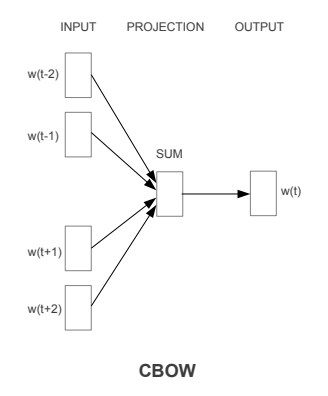
`The CBOW model architecture (Source: https://arxiv.org/pdf/1301.3781.pdf Mikolov el al.)`

The Word2Vec family of models are **unsupervised**, meaning that you can just give it a corpus without additional labels or information and it can construct dense word embeddings from the corpus.

But you will still need to leverage a **supervised, classification methodology** once you have this corpus to get to these embeddings.

We will do that from within the corpus itself, without any auxiliary information.

We can model this **CBOW** architecture now as a deep learning classification model such that we take in the context words as our input, X and try to predict the target word, Y.

In fact building this architecture is simpler than the skip-gram model where we try to predict a whole bunch of context words from a source target word.

## Implementing the Continuous Bag of Words (CBOW) Model
While it’s excellent to use robust frameworks which have the Word2Vec model like gensim, let’s try and **implement this from scratch** to gain some perspective on how things really work behind the scenes.

We will leverage our Bible corpus contained in the norm_bible variable for training our model.

The implementation will focus on four parts:
* Build the corpus vocabulary
* Build a CBOW (context, target) generator
* Build the CBOW model architecture
* Train the Model
* Get Word Embeddings

### Build the corpus vocabulary
To start off, we will first build our corpus vocabulary where we extract out each unique word from our vocabulary and map a unique numeric identifier to it.

In [6]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])


Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


You can see that we have created a vocabulary of unique words in our corpus and also ways to map a word to its unique identifier and vice versa.

The `PAD` term is typically used to pad context words to a fixed length if needed.

### Build a CBOW (context, target) generator
We need pairs which consist of a target centre word and surround context words.

In our implementation, a ***target word*** is of length `1` and ***surrounding context*** is of length `2 x window_size` where we take `window_size` words before and after the target word in our corpus.

This will become clearer with the following example:

In [7]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


The preceding output should give you some more perspective of how ***X*** forms our context words and we are trying to predict the target center word ***Y*** based on this context.

For example, if the original text was *‘in the beginning god **created** heaven and earth’* which after pre-processing and removal of stopwords became *‘beginning god created heaven earth’* and for us, that is what we are trying to achieve.

Given *[beginning, god, heaven, earth]* as the context, what the target center word is, which is ***‘created’*** in this case.

### Build the CBOW model architecture
We now leverage `keras` on top of `tensorflow` to build our deep learning architecture for the CBOW model.

For this our inputs will be our context words which are passed to an embedding layer (initialized with random weights)

The word embeddings are propagated to a lambda layer where we average out the word embeddings ***(hence called CBOW because we don’t really consider the order or sequence in the context words when averaged)*** and then we pass this averaged context embedding to a dense softmax layer which predicts our target word.

We match this with the actual target word, compute the loss by leveraging the `categorical_crossentropy` loss and perform backpropagation with each epoch to update the embedding layer in the process.

Following code shows us our model architecture:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1242500   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12425)             1254925   
                                                                 
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


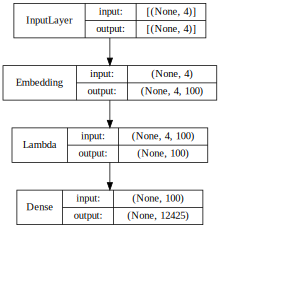

In [8]:
import logging
logging.getLogger('tensorflow').disabled = True
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

We have ***input context words*** of dimensions `(2 x window_size)`, we will pass them to an ***embedding layer** of size `(vocab_size x embed_size)` which will give us dense ***word embeddings*** for each of these context words `(1 x embed_size for each word)`.

Next up we use a ***lambda layer*** to average out these embeddings and get an ***average dense embedding*** `(1 x embed_size)` which is sent to the ***dense softmax layer*** which outputs the most likely target word.

We compare this with the actual target word, compute the loss, backpropagate the errors to adjust the weights (in the embedding layer) and repeat this process for all (*context, target*) pairs for multiple epochs.

The following figure tries to explain the same:
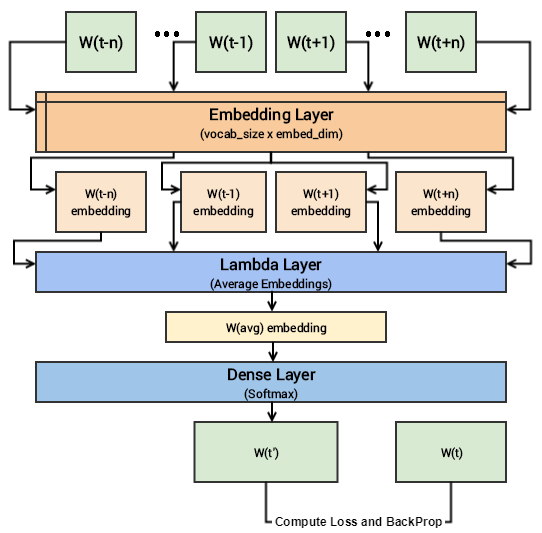
`Visual depiction of the CBOW deep learning model`

We are now ready to train this model on our corpus using our data generator to feed in (*context, target_word*) pairs.

### Train the Model
Running the model on our complete corpus takes a fair bit of time, so I just ran it for 5 epochs. You can leverage the following code and increase it for more epochs if necessary.

In [9]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 4302361.874420295

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 2 	Loss: 5500023.541309938

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 3 	Loss: 5530118.552502259

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 4 	Loss: 5116663.223302663

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 5 	Loss: 4544342.829362681



>**Note:** Running this model is computationally expensive and works better if trained using a GPU. I trained this on an AWS p2.x instance with a Tesla K80 GPU and it took me close to 1.5 hours for just 5 epochs!

Once this model is trained, similar words should have similar weights based off the embedding layer and we can test out the same.

### Get Word Embeddings
To get word embeddings for our entire vocabulary, we can extract out the same from our embedding layer by leveraging the following code. We don’t take the embedding at position 0 since it belongs to the padding `(PAD)` term which is not really a word of interest.

In [10]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

# Word Embeddings for our vocabulary based on the CBOW model

(12424, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
unto,-1.658113,2.092892,1.651633,2.748978,2.487044,-2.484429,2.349877,2.141736,1.684103,2.448739,...,-2.656024,-1.953369,1.864708,2.158958,-2.242337,-2.035357,2.034350,1.821860,2.063500,2.330931
lord,-1.992174,1.997914,2.001726,2.392572,2.289643,-2.235705,2.126675,2.250582,1.465727,2.146610,...,-2.612921,-1.302000,1.587619,2.037715,-1.653020,-2.127049,2.063193,2.005454,1.478597,2.222821
thou,-1.473093,1.684468,1.214930,1.798154,1.591913,-2.035939,1.463480,1.935348,1.377386,1.659830,...,-1.896454,-1.251621,1.820101,1.655717,-1.863812,-1.535613,1.452786,0.995425,1.256922,1.887710
thy,-1.823446,2.024173,1.667571,2.156524,1.817144,-2.651547,2.398401,2.147856,1.790020,2.055657,...,-2.525209,-1.841040,1.884705,2.324648,-1.854777,-1.949135,1.734879,1.742885,2.053027,2.190557
god,-1.565958,1.670241,1.679519,2.045577,1.851510,-2.210920,2.040985,2.259248,1.651888,1.584402,...,-2.295951,-1.217225,1.266874,2.070429,-1.939311,-1.834153,1.770923,1.577608,1.774021,1.726290


Thus you can clearly see that each word has a dense embedding of size `(1x100)` as depicted in the preceding output. Let’s try and find out some contextually similar words for specific words of interest based on these embeddings. For this, we build out a pairwise distance matrix amongst all the words in our vocabulary based on the dense embedding vectors and then find out the n-nearest neighbors of each word of interest based on the shortest (euclidean) distance.

In [11]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

(12424, 12424)


{'god': ['ye', 'lord', 'hath', 'men', 'unto'],
 'jesus': ['sea', 'would', 'holy', 'dead', 'thing'],
 'noah': ['flower', 'neighbours', 'used', 'hasted', 'lusts'],
 'egypt': ['gone', 'princes', 'poor', 'broken', 'till'],
 'john': ['disciples', 'peter', 'entered', 'knew', 'sound'],
 'gospel': ['hope', 'grace', 'hearts', 'must', 'saints'],
 'moses': ['therein', 'enemies', 'kept', 'goeth', 'received'],
 'famine': ['remained', 'fields', 'army', 'lying', 'wheat']}

You can clearly see that some of these make sense contextually (god, heaven), (gospel, church) and so on and some may not. Training for more epochs usually ends up giving better results. We will now explore the skip-gram architecture which often gives better results as compared to CBOW.

In [12]:
import pickle

pickle.dump(cbow, open('cbow-bible-model.pkl','wb'))

### The Skip-gram Model
The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word).

Considering our simple sentence from earlier, ***“the quick brown fox jumps over the lazy dog”***. If we used the CBOW model, we get pairs of ***(context_window, target_word)*** where if we consider a context window of size 2, we have examples like ***([quick, fox], brown)***, ***([the, brown], quick)***, ***([the, dog], lazy)** and so on.

Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. Hence the task becomes to predict the context ***[quick, fox]*** given target word ***‘brown’*** or ***[the, brown]*** given target word ‘quick’ and so on.

Thus the model tries to predict the context_window words based on the target_word.

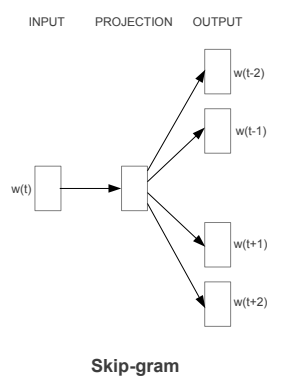
`The Skip-gram model architecture (Source: https://arxiv.org/pdf/1301.3781.pdf Mikolov el al.)`

Just like we discussed in the CBOW model, we need to model this Skip-gram architecture now as a deep learning classification model such that we take in the target word as our input and try to predict the context words.This becomes slightly complex since we have multiple words in our context.

We simplify this further by breaking down each ***(target, context_words)*** pair into ***(target, context)*** pairs such that each context consists of only one word. Hence our dataset from earlier gets transformed into pairs like ***(brown, quick)***, ***(brown, fox)***, ***(quick, the)***, ***(quick, brown)*** and so on.

But how to supervise or train the model to know what is contextual and what is not?

For this, we feed our skip-gram model pairs of ***(X, Y)*** where ***X*** is our ***input*** and ***Y*** is our ***label***. We do this by using ***[(target, context), 1]*** pairs as ***positive input*** samples where ***target*** is our word of interest and ***context*** is a context word occurring near the target word and the ***positive label 1*** indicates this is a contextually relevant pair.

We also feed in ***[(target, random), 0]*** pairs as ***negative input samples*** where ***target*** is again our word of interest but ***random*** is just a randomly selected word from our vocabulary which has no context or association with our target word.

Hence the ***negative label 0*** indicates this is a contextually irrelevant pair. We do this so that the model can then learn which pairs of words are contextually relevant and which are not and generate similar embeddings for semantically similar words.

## Implementing the Skip-gram Model

Let’s now try and implement this model from scratch to gain some perspective on how things work behind the scenes and also so that we can compare it with our implementation of the CBOW model.

We will leverage our Bible corpus as usual which is contained in the norm_bible variable for training our model. The implementation will focus on five parts:

* Build the corpus vocabulary
* Build a skip-gram [(target, context), relevancy] generator
* Build the skip-gram model architecture
* Train the Model
* Get Word Embeddings

Let’s build our skip-gram Word2Vec model:

### Build the corpus vocabulary

To start off, we will follow the standard process of building our corpus vocabulary where we extract out each unique word from our vocabulary and assign a unique identifier, similar to what we did in the CBOW model.

We also maintain mappings to transform words to their unique identifiers and vice-versa.

In [13]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


Just like we wanted, each unique word from the corpus is a part of our vocabulary now with a unique numeric identifier.

### Build a skip-gram [(target, context), relevancy] generator

It’s now time to build out our skip-gram generator which will give us pair of words and their relevance like we discussed earlier. Luckily, **keras has a nifty skipgrams utility which can be used and we don’t have to manually implement this generator like we did in CBOW**.

>Note: The function skipgrams(…) is present in keras.preprocessing.sequence
This function transforms a sequence of word indexes (list of integers) into tuples of words of the form:
> - (word, word in the same window), with label 1 (positive samples).
> - (word, random word from the vocabulary), with label 0 (negative samples).

In [14]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(bible (5766), shihon (9129)) -> 0
(king (13), eber (2798)) -> 0
(king (13), bible (5766)) -> 1
(james (1154), wen (8744)) -> 0
(king (13), james (1154)) -> 1
(king (13), wanted (6530)) -> 0
(bible (5766), james (1154)) -> 1
(james (1154), king (13)) -> 1
(james (1154), maleleel (11521)) -> 0
(james (1154), bible (5766)) -> 1


Thus you can see we have successfully generated our required skip-grams and based on the sample skip-grams in the preceding output, you can clearly see what is relevant and what is irrelevant based on the label (0 or 1).

### Build the skip-gram model architecture

We now leverage keras on top of tensorflow to build our deep learning architecture for the skip-gram model.

For this our inputs will be our target word and context or random word pair. Each of which are passed to an embedding layer (initialized with random weights) of it’s own.

Once we obtain the word embeddings for the target and the context word, we pass it to a merge layer where we compute the dot product of these two vectors.

Then we pass on this dot product value to a dense sigmoid layer which predicts either a 1 or a 0 depending on if the pair of words are contextually relevant or just random words ***(Y’)***.

We match this with the actual relevance label ***(Y)***, compute the loss by leveraging the `mean_squared_error` loss and perform backpropagation with each epoch to update the embedding layer in the process.

Following code shows us our model architecture:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_69_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 embedding_70_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 embedding_69 (Embedding)       (None, 1, 100)       1242500     ['embedding_69_input[0][0]']     
                                                                                              

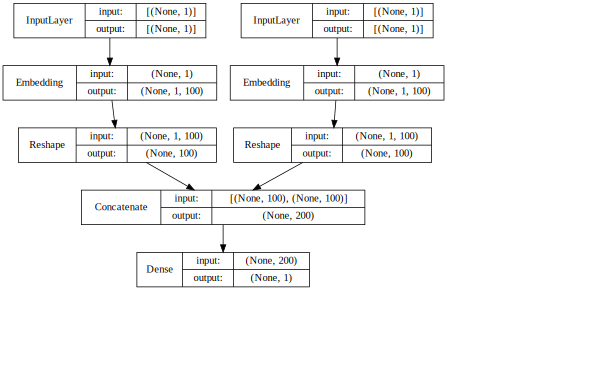

In [54]:
# http://localhost:8888/notebooks/capstone/Curriculum/Section-31--Natural-Language-Processing/Section-31.1--Foundations-of-Traditional-and-Modern-NLP/sandbox.ipynb
from keras.layers import concatenate
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model

# build skip-gram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

#model = Sequential()
#model.add(Merge([word_model, context_model], mode="dot"))
model_concat = concatenate([word_model.output, context_model.output], axis=-1)
#model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model_concat = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(model_concat)
model = Model(inputs=[word_model.input, context_model.input], outputs=model_concat)
model.compile(loss="mean_squared_error", optimizer="rmsprop")

# view model summary
print(model.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

### Train the Model
Running the model on our complete corpus takes a fair bit of time but lesser than the CBOW model. Hence I just ran it for 5 epochs. You can leverage the following code and increase it for more epochs if necessary.

In [55]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3678.167196952272
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3205.3910378175788
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 3122.073724834714
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 3092.8543725128984
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
E

Once this model is trained, similar words should have similar weights based off the embedding layer and we can test out the same.

### Get Word Embeddings
To get word embeddings for our entire vocabulary, we can extract out the same from our embedding layer by leveraging the following code.

Do note that we are only interested in the target word embedding layer, hence we will extract the embeddings from our `word_model` embedding layer.

We don’t take the embedding at position 0 since none of our words in the vocabulary have a numeric identifier of 0 and we ignore it.

In [56]:
merge_layer = model.layers[0]
word_model = merge_layer.layers[0]
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

AttributeError: 'InputLayer' object has no attribute 'layers'

...skipping to next section

### Robust Word2Vec Models with Gensim

While our implementations are decent enough, they are not optimized enough to work well on large corpora. The `gensim` framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. We will leverage the same on our Bible corpus. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.

* **size:** The word embedding dimensionality
* **window:** The context window size
* **min_count:** The minimum word count
* **sample:** The downsample setting for frequent words

After building our model, we will use our words of interest to see the top similar words for each of them.

In [59]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, epochs=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'reasonable', 'worldly', 'sworn', 'us'],
 'jesus': ['peter', 'messias', 'neverthless', 'synagogue', 'immediately'],
 'noah': ['ham', 'shem', 'japheth', 'kenan', 'enosh'],
 'egypt': ['egyptians', 'pharaoh', 'bondage', 'rod', 'lice'],
 'john': ['baptist', 'james', 'peter', 'galilee', 'baptize'],
 'gospel': ['christ', 'preach', 'teaching', 'godly', 'faith'],
 'moses': ['congregation', 'children', 'elisheba', 'ordinance', 'tribes'],
 'famine': ['pestilence', 'peril', 'mildew', 'blasting', 'trespassing']}

The similar words here definitely are more related to our words of interest and this is expected given that we ran this model for more number of iterations which must have yield better and more contextual embeddings. Do you notice any interesting associations?
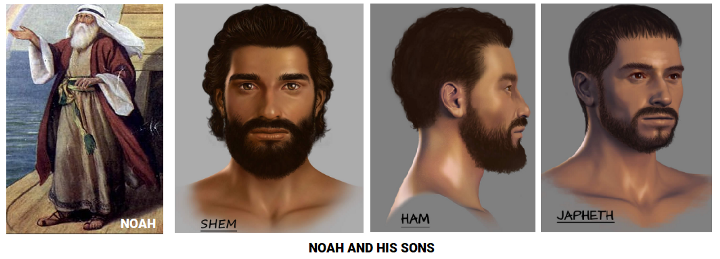
Let’s also visualize the words of interest and their similar words using their embedding vectors after reducing their dimensions to a 2-D space with t-SNE.

/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


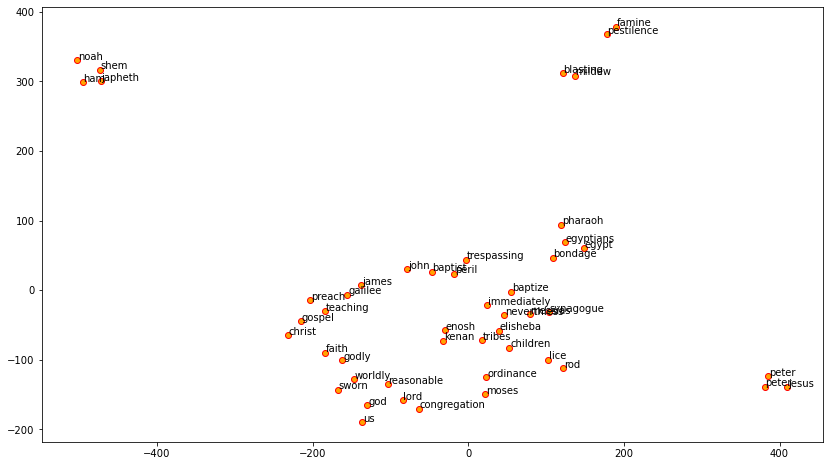

In [60]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

The red circles have been drawn by me to point out some interesting associations which I found out. We can clearly see based on what I depicted earlier that ***noah*** and his sons are quite close to each other based on the word embeddings from our model!

### Applying Word2Vec features for Machine Learning Tasks

If you remember reading the previous article [Part-3: Traditional Methods for Text Data](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41) you might have seen me using features for some actual machine learning tasks like clustering. Let’s leverage our other top corpus and try to achieve the same.

To start with, we will build a simple Word2Vec model on the corpus and visualize the embeddings.

/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


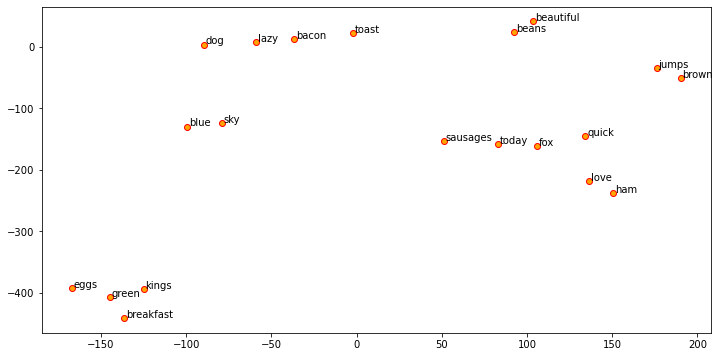

In [63]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, epochs=100)
                              
                              
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    
# Visualizing word2vec word embeddings on our toy corpus:

Remember that our corpus is extremely small so to get meaninful word embeddings and for the model to get more context and semantics, more data helps.

Now what is a word embedding in this scenario? It’s typically a dense vector for each word as depicted in the following example for the word ***sky***.

In [64]:
w2v_model.wv['sky']

array([-0.00550217,  0.00225759,  0.05222183,  0.08953774, -0.09186712,
       -0.07102545,  0.06703831,  0.09108812, -0.05248048, -0.03727873],
      dtype=float32)

Now suppose we wanted to cluster the eight documents from our toy corpus, we would need to get the document level embeddings from each of the words present in each document.

One strategy would be to average out the word embeddings for each word in a document.

This is an extremely useful strategy and you can adopt the same for your own problems.

Let’s apply this now on our corpus to get features for each document:

In [75]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model.wv, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

# Document level embeddings:

,0,1,2,3,4,5,6,7,8,9
0,-0.002563,-0.007418,0.034811,0.026904,-0.053587,-0.035993,0.061499,0.014958,-0.047006,-0.059281
1,0.003990,-0.017028,0.047207,-0.004556,-0.022574,-0.019438,0.034795,0.022913,-0.040348,-0.027406
2,-0.025970,0.044765,-0.027590,-0.042492,0.038190,0.001035,0.020798,0.014793,-0.009800,0.026013
3,-0.004875,-0.023161,0.012324,0.017017,0.023751,0.013767,0.019178,-0.004341,0.008625,0.013524
4,0.002887,-0.026936,0.028622,0.022390,0.038068,0.033622,0.020794,0.024426,-0.022648,0.036913
5,0.000605,0.036747,-0.027230,-0.022999,0.024138,-0.010912,0.013114,0.026146,-0.036314,-0.000790
6,-0.000502,-0.007114,0.035939,0.018142,-0.055835,-0.030537,0.061412,0.022556,-0.058082,-0.034085
7,-0.013937,0.047206,-0.023748,-0.040617,0.038326,-0.009574,0.009073,0.029035,-0.026323,0.017736


Now that we have our features for each document, let’s cluster these documents using the [Affinity Propagation algorithm](https://en.wikipedia.org/wiki/Affinity_propagation), which is a clustering algorithm based on the concept of “*message passing”* between data points and does not need the number of clusters as an explicit input which is often required by partition-based clustering algorithms.

In [76]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

# Clusters assigned based on our document features from word2vec

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,1
7,The dog is lazy but the brown fox is quick!,animals,2


We can see that our algorithm has clustered each document into the right group based on our Word2Vec features.

We can also visualize how each document in positioned in each cluster by using [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the feature dimensions to 2-D and then visualizing the same (by color coding each cluster).

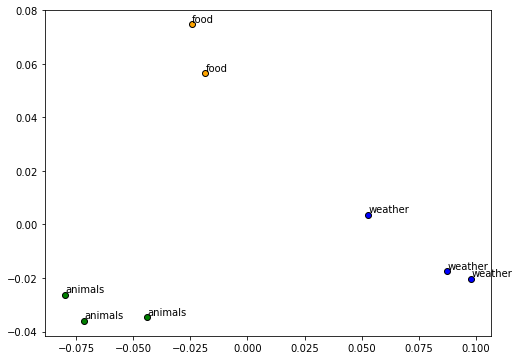

In [77]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')
    
    # Visualizing our document clusters:

### The GloVe Model

The GloVe model stands for ***Global Vectors*** which is an **unsupervised learning model** which can be used to obtain dense word vectors similar to ***Word2Vec***.

However the technique is different and training is performed on an aggregated global word-word co-occurrence matrix, giving us a vector space with meaningful sub-structures.

This method was invented in Stanford by Pennington et al. and I recommend you to read the original paper on GloVe, [‘GloVe: Global Vectors for Word Representation’](https://nlp.stanford.edu/pubs/glove.pdf) by Pennington et al. which is an excellent read to get some perspective on how this model works.

The basic methodology of the GloVe model is to first create a huge word-context co-occurence matrix consisting of (word, context) pairs such that each element in this matrix represents how often a word occurs with the context (which can be a sequence of words). The idea then is to apply matrix factorization to approximate this matrix as depicted in the following figure:
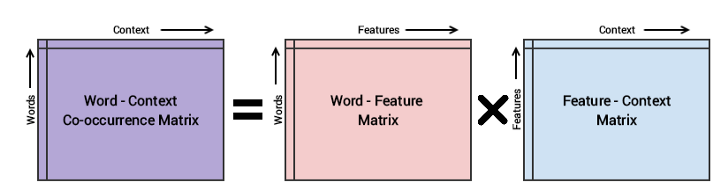
`Conceptual model for the GloVe model’s implementation`

Considering the ***Word-Context (WC)*** matrix, ***Word-Feature (WF) matrix*** and ***Feature-Context (FC) matrix***, we try to factorize `WC = WF x FC`, such that we we aim to reconstruct WC from WF and FC by multiplying them.

For this, we typically initialize *WF* and *FC* with some random weights and attempt to multiply them to get *WC’* (an approximation of WC) and measure how close it is to *WC*.

We do this multiple times using [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) to minimize the error.

Finally, the ***Word-Feature matrix (WF)*** gives us the word embeddings for each word where *F* can be preset to a specific number of dimensions.

A very important point to remember is that both Word2Vec and GloVe models are very similar in how they work.

Both of them aim to build a vector space where the position of each word is influenced by its neighboring words based on their context and semantics.

Word2Vec starts with local individual examples of word co-occurrence pairs and GloVe starts with global aggregated co-occurrence statistics across all words in the corpus.

### Applying GloVe features for Machine Learning Tasks

Let’s try and leverage GloVe based embeddings for our document clustering task. The very popular `spacy` framework comes with capabilities to leverage GloVe embeddings based on different language models.

You can also get [pre-trained word vectors](https://nlp.stanford.edu/projects/glove/) and load them up as needed using `gensim` or `spacy`.

We will first install spacy and use the [en_vectors_web_lg](https://spacy.io/models/en#en_vectors_web_lg) model which consists of 300-dimensional word vectors trained on [Common Crawl](http://commoncrawl.org/) with GloVe.

In [86]:
import spacy

nlp = spacy.load('en_core_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 514157


This validates that everything is working and in order. Let’s get the GloVe embeddings for each of our words now in our toy corpus.

In [87]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

# GloVe embeddings for words in our toy corpus:

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
brown,-3.84290,0.140680,-3.35840,3.267900,-2.15360,-6.508500,0.235120,6.884500,-0.543490,3.596900,...,-1.592000,1.02690,1.60640,-2.84040,-2.274700,2.10020,5.480200,0.83172,-4.30830,-1.04370
quick,2.63220,2.707800,-1.19830,2.149000,3.34010,-2.768000,0.285130,0.959040,-3.211000,0.978550,...,1.742100,-0.82167,2.79760,0.21357,1.293800,0.10757,0.832680,-0.80778,-1.53100,-0.28953
beans,0.93585,-0.450810,-4.95600,2.254800,1.21050,-1.667600,0.879590,0.004286,-4.167800,3.960000,...,3.116600,1.10070,4.04960,-0.97496,-5.127300,-0.63158,6.890100,-0.34744,2.44190,0.90073
love,2.05650,-3.225900,-5.73640,-6.146000,0.15748,-2.428400,7.658000,2.706400,-2.211000,-0.899900,...,1.580200,1.75970,-0.60806,-6.61070,0.009383,-4.27630,-0.505070,5.00490,-8.53120,-1.49670
green,-1.93390,0.314870,-4.39510,1.924700,-2.04800,-5.712100,-0.956200,2.792700,-1.307100,3.660400,...,-2.795100,0.43909,2.74080,-2.18080,-0.936220,1.71610,4.210300,-0.44140,-3.99350,-0.57955
jumps,2.04220,3.634600,0.49222,0.074497,1.18540,2.842600,-0.042565,5.634800,0.948340,0.402610,...,-0.538160,3.18240,1.99210,-1.43010,-0.164580,2.53300,-0.051668,1.00780,-0.29046,-1.68560
beautiful,-0.18931,-0.706820,-3.17310,-4.140700,0.70243,-0.692550,2.348700,1.708300,-0.927380,3.484300,...,0.594240,2.14920,3.27380,-1.28600,1.950500,-0.67481,-0.930960,3.28140,-5.52320,-0.31346
lazy,-1.58880,0.733160,1.07460,-2.452100,-0.42517,3.334400,-0.179420,-1.092400,-0.093904,0.058663,...,1.125300,-2.35530,3.93600,-3.37510,-0.999340,1.26390,-2.106800,3.07430,-4.42900,3.89380
blue,-4.31020,2.570600,-3.47220,2.520500,-1.11040,-5.101400,-1.481200,4.655900,0.383650,2.477200,...,-5.250500,4.20530,2.92490,-0.93310,0.890710,6.85240,0.075678,1.07370,-2.96000,-0.42209
sausages,-0.95324,-3.505800,-1.52990,2.149900,3.81270,-1.850400,-0.960970,1.255800,-2.262700,1.484200,...,3.824700,-0.62691,2.76300,-5.66990,-0.950370,-0.58964,2.101200,1.12920,0.98625,0.59990


We can now use t-SNE to visualize these embeddings similar to what we did using our Word2Vec embeddings.

/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dave/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


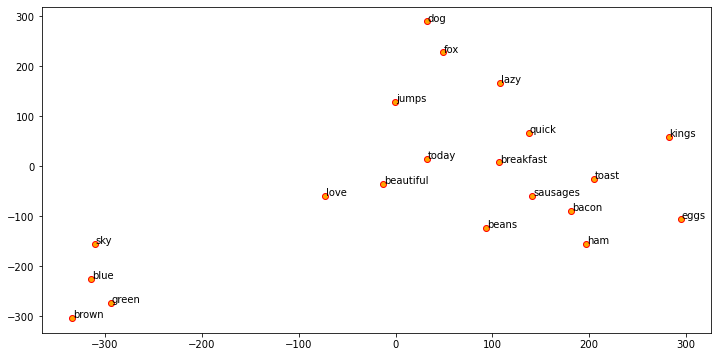

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    
# Visualizing GloVe word embeddings on our toy corpus:

The beauty of spacy is that it will automatically provide you the averaged embeddings for words in each document without having to implement a function like we did in Word2Vec.

We will leverage the same to get document features for our corpus and use [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering to cluster our documents.

In [92]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

# Clusters assigned based on our document features from GloVe:

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,1
7,The dog is lazy but the brown fox is quick!,animals,2


We see consistent clusters similar to what we obtained from our Word2Vec model.

The GloVe model claims to perform better than the Word2Vec model in many scenarios as illustrated in the following graph from the [original paper by Pennington el al](https://nlp.stanford.edu/pubs/glove.pdf).
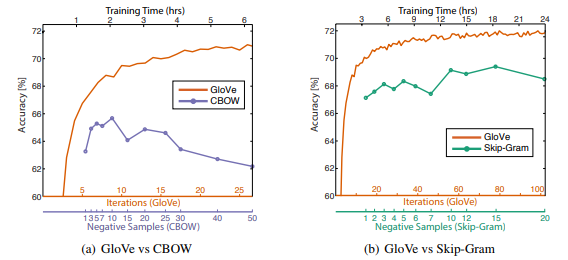
`GloVe vs Word2Vec performance (Source: https://nlp.stanford.edu/pubs/glove.pdf by Pennington et al.)`

## The FastText Model

The [FastText](https://fasttext.cc/) model was first introduced by Facebook in 2016 as an extension and supposedly improvement of the vanilla Word2Vec model. Based on the original paper titled [‘Enriching Word Vectors with Subword Information’ by Mikolov et al.](https://arxiv.org/pdf/1607.04606.pdf) which is an excellent read to gain an in-depth understanding of how this model works.

Overall, FastText is a framework for learning word representations and also performing robust, fast and accurate text classification. The framework is open-sourced by Facebook on GitHub and claims to have the following:
* Recent state-of-the-art [English word vectors](https://fasttext.cc/docs/en/english-vectors.html).
* Word vectors for [157 languages trained on Wikipedia and Crawl](https://github.com/facebookresearch/fastText/blob/master/docs/crawl-vectors.md).
* Models for [language identification](https://fasttext.cc/docs/en/language-identification.html#content) and [various supervised tasks](https://fasttext.cc/docs/en/supervised-models.html#content).

In general, predictive models like the Word2Vec model typically considers each word as a distinct entity (e.g. ***where***) and generates a dense embedding for the word.

However this poses to be a serious limitation with languages having massive vocabularies and many rare words which may not occur a lot in different corpora.

The Word2Vec model typically ignores the morphological structure of each word and considers a word as a single entity.

The FastText model *considers each word as a Bag of Character n-grams*. This is also called as a *subword model* in the paper.

We add special boundary symbols `<` and `>` at the beginning and end of words. This enables us to distinguish prefixes and suffixes from other character sequences.

We also include the word *w* itself in the set of its n-grams, to learn a representation for each word (in addition to its character n-grams).

Taking the word *where* and *n=3* (tri-grams) as an example, it will be represented by the character n-grams: `<wh, whe, her, ere, re>` and the special sequence `<where>` representing the whole word.

Note that the sequence, corresponding to the word `<her>` is different from the tri-gram *her* from the word *where.*

In practice, the paper recommends in extracting all the n-grams for *n ≥ 3* and *n ≤ 6*.

This is a very simple approach, and different sets of n-grams could be considered, for example taking all prefixes and suffixes. 

We typically associate a vector representation (embedding) to each n-gram for a word. Thus, we can represent a word by the sum of the vector representations of its n-grams or the average of the embedding of these n-grams.

Thus, due to this effect of leveraging n-grams from individual words based on their characters, there is a higher chance for rare words to get a good representation since their character based n-grams should occur across other words of the corpus.

## Applying FastText features for Machine Learning Tasks

The `gensim` package has nice wrappers providing us interfaces to leverage the FastText model available under the `gensim.models.fasttext` module.

Let’s apply this once again on our ***Bible corpus*** and look at our words of interest and their most similar words.

In [95]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(tokenized_corpus, vector_size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, epochs=50)
                    
                    
# view similar words based on gensim's FastText model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'unto', 'therefore', 'christ', 'jesus'],
 'jesus': ['christ', 'disciples', 'world', 'god', 'faith'],
 'noah': ['methuselah', 'shem', 'milcah', 'flood', 'creepeth'],
 'egypt': ['land', 'pharaoh', 'egyptians', 'israel', 'pathros'],
 'john': ['baptist', 'baptize', 'peter', 'philip', 'baptized'],
 'gospel': ['preached', 'preach', 'christ', 'preaching', 'grace'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'israel'],
 'famine': ['pestilence', 'sword', 'egypt', 'dearth', 'blasted']}

You can see a lot of similarity in the results with our Word2Vec model with relevant similar words for each of our words of interest. Do you notice any interesting associations and similarities?

>Note: Running this model is computationally expensive and usually takes more time as compared to the skip-gram model since it considers n-grams for each word. This works better if trained using a GPU or a good CPU. I trained this on an AWS p2.x instance and it took me around 10 minutes as compared to over 2–3 hours on a regular system.

Let’s now use [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the word embedding dimensions to 2-D and then visualize the same.

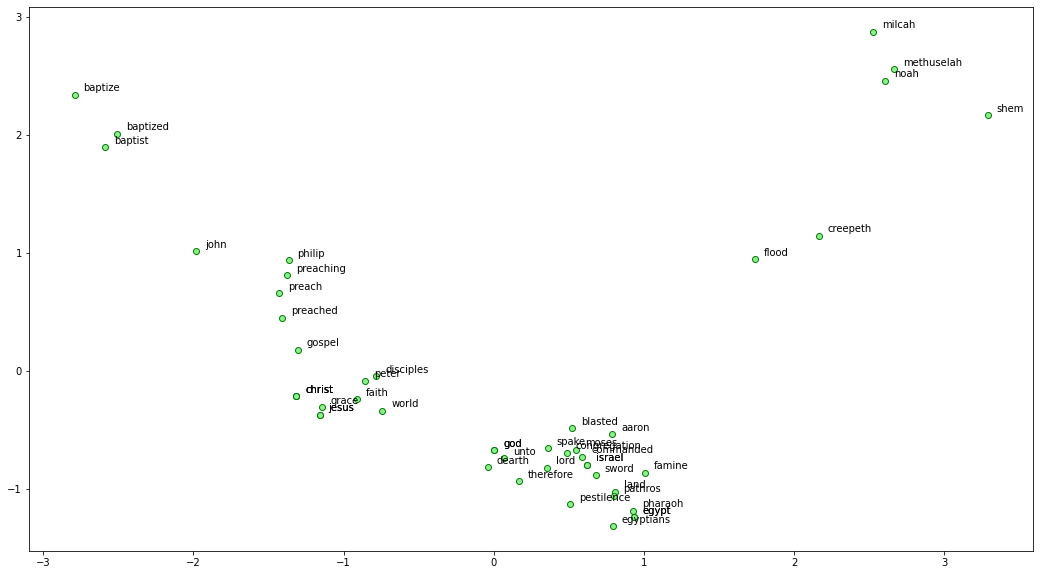

In [96]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

We can see a lot of interesting patterns: *Noah*, his son *Shem* and grandfather *Methuselah* are close to each other. We also see *God* associated with *Moses* and *Egypt* where it endured the Biblical plagues including *famine* and *pestilence*. Also *Jesus* and some of his *disciples* are associated close to each other.

To access any of the word embeddings you can just index the model with the word as follows:

In [97]:
ft_model.wv['jesus']

array([-0.12657648,  0.03200502, -0.27343312,  0.0501005 ,  0.37116763,
        0.55776656,  0.32436925,  0.19720975,  0.2383593 , -0.37331274,
       -0.78795075,  0.43698978, -0.46342328,  0.5795185 , -0.19618082,
       -0.30492556,  0.06095351, -0.02825664, -0.26111165,  0.31596196,
        0.06635787, -0.38283917, -0.00378513,  0.24186221, -0.12680751,
       -0.22205883, -0.38144043,  0.02995942,  0.16652073,  0.29100266,
        0.43268284,  0.5843459 , -0.1298431 , -0.04571392,  0.00114465,
        0.3527632 , -0.25409493,  0.10047872, -0.33557883, -0.24445091,
        0.09642799, -0.22740611,  0.45668375,  0.19037233,  0.23759285,
        0.40172768,  0.0859481 , -0.19831866,  0.21663506,  0.05226139,
       -0.04823257, -0.3196837 ,  0.3001915 ,  0.21478587, -0.2727974 ,
        0.20556344,  0.11014356, -0.1643828 , -0.1843803 , -0.32961687,
       -0.06120753,  0.31585494, -0.3456287 ,  0.24216582,  0.05037879,
        0.08613857,  0.32734782,  0.4350625 , -0.05091913,  0.05

Having these embeddings, we can perform some interesting natural language tasks. One of these would be to find out similarity between different words (entities).

In [98]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

0.31909844
0.63524115


We can see that *‘god’* is more closely associated with *‘jesus’* rather than *‘satan’* based on the text in our Bible corpus.

Considering word embeddings being present, we can even find out odd words from a bunch of words as follows:

In [99]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:',  
      ft_model.wv.doesnt_match(st1.split()))
st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', 
      ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas


Interesting and relevant results in both cases for the odd entity amongst the other words.

## Conclusion

These examples should give you a good idea about newer and efficient strategies around leveraging deep learning language models to extract features from text data and also address problems like word semantics, context and data sparsity.